<a href="https://colab.research.google.com/github/Tasrina18/ASD_classification-_-_other_analysis-Thesis-/blob/main/Ensembleruns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
from PIL import Image
from scipy import misc

import os



from sklearn.metrics import classification_report, confusion_matrix


# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

In [ ]:
!pip install --upgrade nilearn

from nilearn.datasets import fetch_abide_pcp
abide = fetch_abide_pcp(derivatives = ['rois_cc400'], pipeline = 'cpac', DSM_IV_TR=[0,1], quality_checked = False)

y = abide.phenotypic['DX_GROUP']
y[y==2] = 0

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nilearn.connectome import ConnectivityMeasure
from sklearn.metrics import classification_report, confusion_matrix

y[y==2] = 0
conn_est = ConnectivityMeasure(kind = 'correlation', vectorize=True, discard_diagonal=True )
conn_matrices = conn_est.fit_transform(abide.rois_cc400)

#X = sym_matrix_to_vec(conn_matrices)

In [ ]:
conn_matrices.shape

(838, 76636)

In [ ]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(conn_matrices)


n_components = 838
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance with {n_components} components: {explained_variance * 100:.2f}%")

Explained Variance with 838 components: 100.00%


Ensemble with PCA (0,1)

In [ ]:
import time

start_time = time.time()
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

svc = SVC( C=10, kernel='rbf')
linear_svc = LinearSVC(C=0.00001)
ridge_classifier = RidgeClassifier(alpha=1000, tol=0.001, solver='auto')
logistic_regression = LogisticRegression(C=1, max_iter = 1000)


voting_clf = VotingClassifier(
    estimators=[

        ('linear_svc', linear_svc),
        ('ridge_classifier', ridge_classifier),
        ('logistic_regression', logistic_regression)

    ],
    voting='hard'
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)


cv_scores = cross_val_score(voting_clf, X_reduced, y, cv=cv, scoring='accuracy')
y_pred = cross_val_predict(voting_clf, X_reduced, y, cv=cv, method='predict')
cm = confusion_matrix(y, y_pred)


print("Cross-validation scores:", cv_scores)


print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time} seconds")


Cross-validation scores: [0.79761905 0.67857143 0.73809524 0.80952381 0.73809524 0.80952381
 0.78571429 0.73809524 0.72289157 0.78313253]
Mean Accuracy: 0.7601
Standard Deviation: 0.0412
Time elapsed: 16.949125289916992 seconds


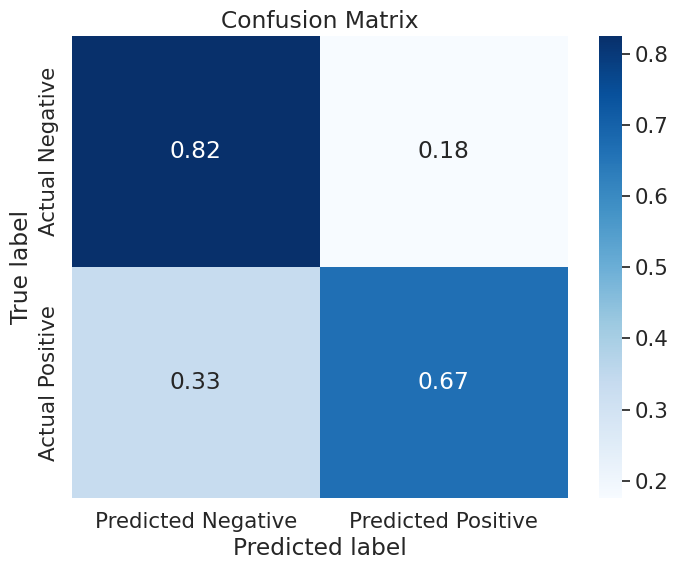

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

recall = cross_val_score(voting_clf, conn_matrices, y, scoring = 'recall',cv = cv, verbose = 1)
precision = cross_val_score(voting_clf, conn_matrices, y, scoring = 'precision',cv = cv, verbose = 1)

cross_recall = np.mean(recall)
cross_precision = np.mean(precision)

print("cross_recall:",cross_recall)
print("cross_precision:",cross_precision)

cross_recall: 0.5876470588235294
cross_precision: 0.7479716368170206


In [ ]:
recall

array([0.57142857, 0.62857143, 0.52941176, 0.61764706, 0.5       ,
       0.64705882, 0.52941176, 0.58823529, 0.61764706, 0.64705882])

Ensemble without pca (0,1)

In [ ]:
import time

start_time = time.time()
from sklearn.model_selection import cross_val_score, StratifiedKFold,cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

svc = SVC(gamma='auto', C=10, kernel='rbf', probability=True)
linear_svc = LinearSVC(C=0.001, penalty='l2', tol=0.0001)
ridge_classifier = RidgeClassifier(alpha=1000, tol=0.001, solver='auto')
logistic_regression = LogisticRegression(C=1, max_iter = 1000)


voting_clf = VotingClassifier(
    estimators=[
        ('linear_svc', linear_svc),
        ('ridge_classifier', ridge_classifier),
        ('logistic_regression', logistic_regression)
    ],
    voting='hard'
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)


cv_scores = cross_val_score(voting_clf, conn_matrices, y, cv=cv, scoring='accuracy')
y_pred = cross_val_predict(voting_clf, conn_matrices, y, cv=cv, method='predict')
cm = confusion_matrix(y, y_pred)


print("Cross-validation scores:", cv_scores)


print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

end_time = time.time()


elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time} seconds")


Cross-validation scores: [0.73809524 0.71428571 0.71428571 0.78571429 0.72619048 0.79761905
 0.75       0.71428571 0.72289157 0.77108434]
Mean Accuracy: 0.7434
Standard Deviation: 0.0297
Time elapsed: 2112.512647628784 seconds
Cross-validation scores: [0.73809524 0.71428571 0.71428571 0.78571429 0.72619048 0.79761905
 0.75       0.71428571 0.72289157 0.77108434]
Mean Accuracy: 0.7434
Standard Deviation: 0.0297
Time elapsed: 2112.512647628784 seconds


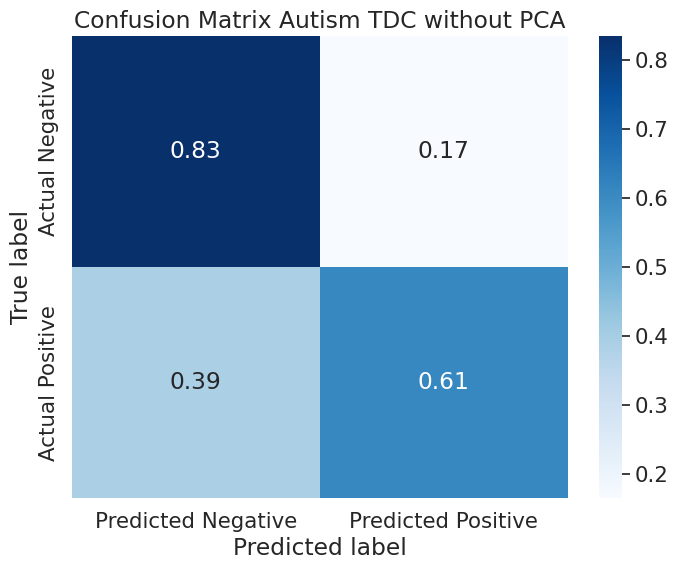

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix Autism TDC without PCA')
plt.show()


#ASD vs TDC


In [ ]:
!pip install --upgrade nilearn

from nilearn.datasets import fetch_abide_pcp
abide = fetch_abide_pcp(derivatives = ['rois_cc400'], pipeline = 'cpac', quality_checked = False)

y1= abide.phenotypic['DX_GROUP']
y1[y1==2] = 0

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nilearn.connectome import ConnectivityMeasure
from sklearn.metrics import classification_report, confusion_matrix

y1[y1==2] = 0
conn_est = ConnectivityMeasure(kind = 'correlation', vectorize=True, discard_diagonal=True )
connn_matrices = conn_est.fit_transform(abide.rois_cc400)

#X = sym_matrix_to_vec(conn_matrices)

In [ ]:
connn_matrices.shape

(1035, 76636)

In [ ]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np


scaler = StandardScaler()
X_scaledfull = scaler.fit_transform(connn_matrices)


n_components = 1035
pca = PCA(n_components=n_components)
X_reducedfull = pca.fit_transform(X_scaledfull)


explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance with {n_components} components: {explained_variance * 100:.2f}%")

Explained Variance with 1035 components: 100.00%


In [ ]:
X_reducedfull.shape


(1035, 1035)

Ensemble with PCA (full dataset)


In [ ]:
import time


start_time = time.time()
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


svc = SVC(gamma='auto', C=10, kernel='rbf', probability=True)
linear_svc = LinearSVC(C=0.001, penalty='l2', tol=0.0001)
ridge_classifier = RidgeClassifier(alpha=1000, tol=0.001, solver='auto')
logistic_regression = LogisticRegression(C=1, max_iter = 1000)

voting_clf = VotingClassifier(
    estimators=[

        ('linear_svc', linear_svc),
        ('ridge_classifier', ridge_classifier),
        ('logistic_regression', logistic_regression)
    ],
    voting='hard'
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)


cv_scores = cross_val_score(voting_clf, X_reducedfull, y1, cv=cv, scoring='accuracy')

y_pred = cross_val_predict(voting_clf, X_reducedfull, y1, cv=cv, method='predict')
cm = confusion_matrix(y1, y_pred)

print("Cross-validation scores:", cv_scores)


print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

end_time = time.time()


elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time} seconds")


Cross-validation scores: [0.71980676 0.66183575 0.7294686  0.71497585 0.71980676]
Mean Accuracy: 0.7092
Standard Deviation: 0.0241
Time elapsed: 22.353803157806396 seconds


In [ ]:
import time
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


start_time = time.time()


svc = SVC(gamma='auto', C=10, kernel='rbf', probability=True)
linear_svc = LinearSVC(C=0.001, penalty='l2', tol=0.0001)
ridge_classifier = RidgeClassifier(alpha=1000, tol=0.001, solver='auto')
logistic_regression = LogisticRegression(C=1, max_iter=1000)


voting_clf = VotingClassifier(
    estimators=[
        ('svc', svc),
        ('linear_svc', linear_svc),
        ('ridge_classifier', ridge_classifier),
        ('logistic_regression', logistic_regression)
    ],
    voting='hard'
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

cv_scores = cross_val_score(voting_clf, X_reducedfull, y1, cv=cv, scoring='accuracy')

y_pred = cross_val_predict(voting_clf, X_reducedfull, y1, cv=cv, method='predict')
cm = confusion_matrix(y1, y_pred)


print("Cross-validation scores:", cv_scores)


print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

end_time = time.time()


elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time} seconds")




Cross-validation scores: [0.71980676 0.68115942 0.73429952 0.70531401 0.74396135]
Mean Accuracy: 0.7169
Standard Deviation: 0.0222
Time elapsed: 44.390753746032715 seconds


In [ ]:
cm

array([[403, 127],
       [166, 339]])

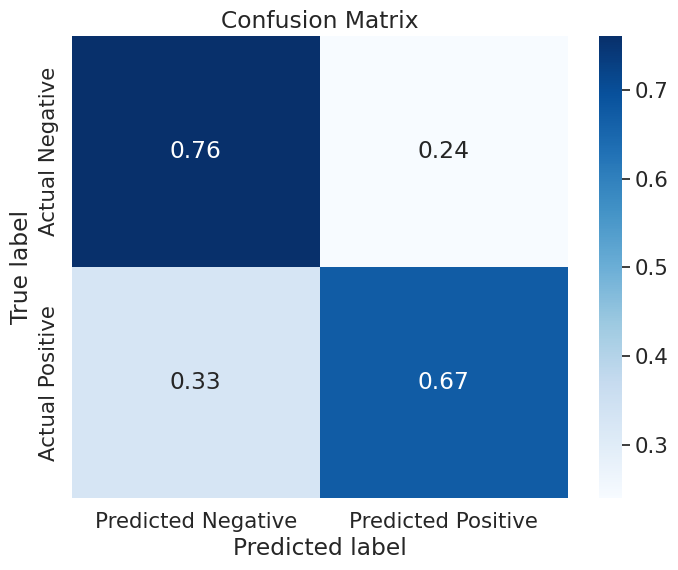

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

#recall == sensitivity
recall = cross_val_score(voting_clf, X_reducedfull, y1, scoring = 'recall',cv = cv, verbose = 1)
precision = cross_val_score(voting_clf, X_reducedfull, y1, scoring = 'precision',cv = cv, verbose = 1)

cross_recall = np.mean(recall)
cross_precision = np.mean(precision)

print("cross_recall:",cross_recall)
print("cross_precision:",cross_precision)

cross_recall: 0.7187058823529411
cross_precision: 0.7173952654622421


Ensemble without PCA (full dataset)

In [ ]:
import time

start_time = time.time()
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


svc = SVC(gamma='auto', C=10, kernel='rbf', probability=True)
linear_svc = LinearSVC(C=0.001, penalty='l2', tol=0.0001)
ridge_classifier = RidgeClassifier(alpha=1000, tol=0.001, solver='auto')
logistic_regression = LogisticRegression(C=1, max_iter = 1000)


voting_clf = VotingClassifier(
    estimators=[

        ('linear_svc', linear_svc),
        ('ridge_classifier', ridge_classifier),
        ('logistic_regression', logistic_regression)
    ],
    voting='hard'
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

cv_scores = cross_val_score(voting_clf, connn_matrices, y1, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)


print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
end_time = time.time()


elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time} seconds")

Cross-validation scores: [0.75961538 0.71153846 0.68269231 0.65384615 0.68269231 0.72815534
 0.76699029 0.72815534 0.81553398 0.67961165]
Mean Accuracy: 0.7209
Standard Deviation: 0.0468
Time elapsed: 1232.548655986786 seconds


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

recall = cross_val_score(voting_clf, connn_matrices, y1, scoring = 'recall',cv = cv, verbose = 1)
precision = cross_val_score(voting_clf, connn_matrices, y1, scoring = 'precision',cv = cv, verbose = 1)

cross_recall = np.mean(recall)
cross_precision = np.mean(precision)

print("cross_recall:",cross_recall)
print("cross_precision:",cross_precision)

cross_recall: 0.7069019607843138
cross_precision: 0.7205637624703112
